# Proyecto XAI 
## Clasificación de Imágenes Reales vs Generadas por IA

Este notebook implementa un clasificador de redes neuronales convolucionales para distinguir entre imágenes reales y generadas por IA.

In [ ]:
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')
!kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
Archive:  cifake-real-and-ai-generated-synthetic-images.zip
  inflating: test/FAKE/0 (10).jpg    
  inflating: test/FAKE/0 (2).jpg     
  inflating: test/FAKE/0 (3).jpg     
  inflating: test/FAKE/0 (4).jpg     
  inflating: test/FAKE/0 (5).jpg     
  inflating: test/FAKE/0 (6).jpg     
  inflating: test/FAKE/0 (7).jpg     
  inflating: test/FAKE/0 (8).jpg     
  inflating: test/FAKE/0 (9).jpg     
  inflating: test/FAKE/0.jpg         
  inflating: test/FAKE/1 (10).jpg    
  inflating: test/FAKE/1 (2).jpg     
  inflating: test/FAKE/1 (3).jpg     
  inflating: test/FAKE/1 (4).jpg     
  inflating: test/FAKE/1 (5).jpg     
  inflating: test/FAKE/1 (6).jpg     
  inflating: test/FAKE/1 (7).jpg     
  inflating: test/FAKE/1 (8).jpg     
  inflating: test/FAKE/1 (9).jpg     
  inflating: test/FAKE/1.jpg         
  inflating: test/FAKE/10 (10).jpg   
  inflating: test/FAKE/1

## 1. Importar bibliotecas necesarias

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image
import tqdm as tqdm
from sklearn.utils import shuffle

# Lime|
from lime import lime_image 
from skimage.segmentation import mark_boundaries

# Comprobar si estamos usando GPU
TF_CPP_MIN_LOG_LEVEL = 3
print(tf.config.list_physical_devices('GPU'))

# Configurar semilla aleatoria para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

2025-05-22 16:55:10.339378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747947310.361336   21926 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747947310.368090   21926 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747947310.395238   21926 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747947310.395258   21926 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747947310.395259   21926 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Definir función para cargar el conjunto de datos

In [4]:
file_path = ''
img_size = 224
batch_size = 64

def get_labels(path):
    all_image_paths = []
    all_labels = []
    class_names = ['FAKE', 'REAL']

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(path, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in image_files:
                img_path = os.path.join(class_dir, img_file)
                all_image_paths.append(img_path)
                all_labels.append(class_idx)

    # Convertir a arrays numpy
    all_image_paths = np.array(all_image_paths)
    all_labels = np.array(all_labels)
    return all_image_paths, all_labels

# Define función para cargar y preprocesar imágenes
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normaliza a [0,1]
    img = tf.image.resize(img, [img_size, img_size])
    label = tf.cast(label, tf.float32)
    return img, tf.reshape(label, (1,))


def load_dataset(paths, labels, batch_size, shuffle_data=True):
    """
    Crea un generador de datos que carga imágenes por lotes para ahorrar memoria.
    """    
    
    # Mezclar datos si es necesario
    if shuffle_data:
        indices = np.arange(len(paths))
        np.random.seed(42)
        np.random.shuffle(indices)
        paths = paths[indices]
        labels = labels[indices]
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # Apply preprocessing, batching and prefetching
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

## 3. Cargar y preparar los datos

In [8]:
# Establecer rutas a las carpetas de datos
train_dir = 'train'  


# Crear sets de entrenamiento y validación
data_dir = os.path.join(file_path, train_dir)

# Obtener rutas de imágenes y etiquetas
all_image_paths, all_labels = get_labels(data_dir)

# Dividir en conjuntos de entrenamiento y validación
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

# Crear datasets
train_ds = load_dataset(train_paths, train_labels, batch_size)
val_ds = load_dataset(val_paths, val_labels, batch_size)

print(f"Conjunto de entrenamiento: {len(train_paths)} imágenes")
print(f"Conjunto de validación: {len(val_paths)} imágenes")

Conjunto de entrenamiento: 80000 imágenes
Conjunto de validación: 20000 imágenes


2025-05-22 16:56:34.638155: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


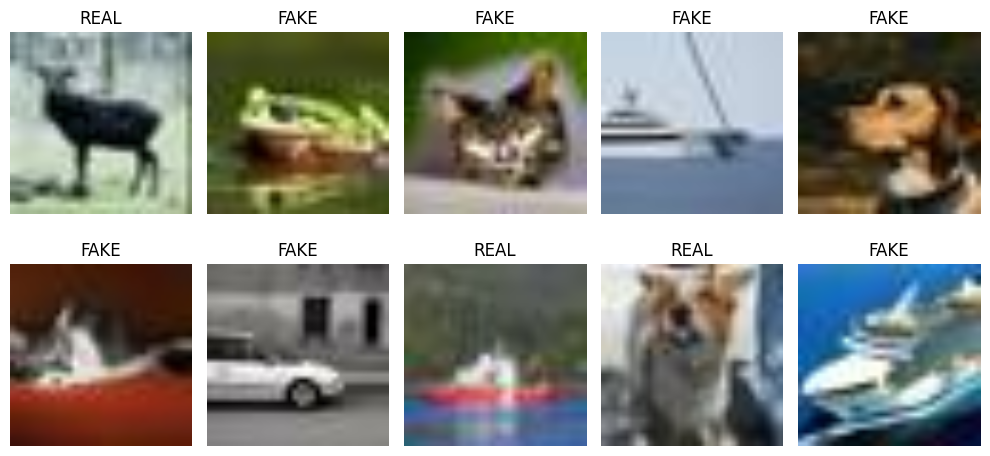

In [9]:
# Visualizar algunas imágenes de ejemplo
sample_size = 10
sample_images, sample_labels = [], []
for images, labels in train_ds.take(1):  # Take just one batch
    for i in range(min(sample_size, len(images))):
        sample_images.append(images[i].numpy())
        sample_labels.append(labels[i].numpy())

# Visualize sample images
plt.figure(figsize=(10, 5))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    class_name = ['FAKE', 'REAL'][int(sample_labels[i][0])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Definir arquitectura del modelo

### Modelo Propio


In [10]:
# Aumentación de datos para entrenamiento

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Definir el modelo
input_shape = (img_size, img_size, 3)
model = models.Sequential([
    layers.Input(input_shape),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='last_conv_layer'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu', name='output_layer'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,177 (6.42 MB)

 Trainable params: 1,681,793 (6.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Programador de tasa de aprendizaje
'''
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)
'''

# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [12]:
# Entrenar el modelo
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=100,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

Epoch 1/100


I0000 00:00:1747947425.033268   22069 service.cc:152] XLA service 0x7faa70006670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747947425.033319   22069 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-22 16:57:05.066376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747947425.271137   22069 cuda_dnn.cc:529] Loaded cuDNN version 90501


   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:09 56ms/step - accuracy: 0.5642 - f1_score: 0.4079 - loss: 8.9170

I0000 00:00:1747947429.637374   22069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7803 - f1_score: 0.7767 - loss: 0.6699
Epoch 1: val_accuracy improved from -inf to 0.86325, saving model to CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 66ms/step - accuracy: 0.7804 - f1_score: 0.7767 - loss: 0.6696 - val_accuracy: 0.8633 - val_f1_score: 0.8724 - val_loss: 0.3118
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8965 - f1_score: 0.8973 - loss: 0.2483
Epoch 2: val_accuracy improved from 0.86325 to 0.88280, saving model to CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.8966 - f1_score: 0.8973 - loss: 0.2483 - val_accuracy: 0.8828 - val_f1_score: 0.8894 - val_loss: 0.2847
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9131 - f1_score: 0.9134 - loss: 0.2177
Epoch 3: val_accuracy improved from 0.88280 to 0.89525, saving model to CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - accuracy: 0.9131 - f1_score: 0.9134 - loss: 0.2177 - val_acc

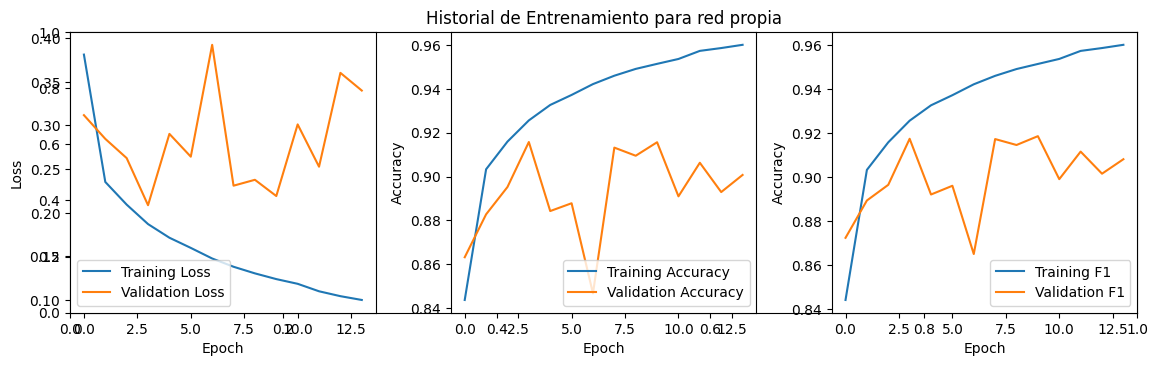

In [13]:
# Graficar historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.title('Historial de Entrenamiento para red propia')

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')   
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('historial_entrenamiento.png')
plt.show()

### VGG16

In [6]:
# Utilizar transfer learning con VGG16
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congelar las capas de la base para evitar que se entrenen
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Aumentación de datos para entrenamiento

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #'CIFAKE.keras',
    'VGG_CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [8]:
# Entrenar el modelo
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=10,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

Epoch 1/10


I0000 00:00:1747941352.132817    3546 service.cc:152] XLA service 0x7f654000e640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747941352.132913    3546 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-22 15:15:52.169190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747941352.480621    3546 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-22 15:15:53.920013: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 3:50:07 11s/step - accuracy: 0.5625 - f1_score: 0.5625 - loss: 0.7304

I0000 00:00:1747941362.140287    3546 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8095 - f1_score: 0.8111 - loss: 0.4700
Epoch 1: val_accuracy improved from -inf to 0.89160, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 189s 143ms/step - accuracy: 0.8095 - f1_score: 0.8111 - loss: 0.4699 - val_accuracy: 0.8916 - val_f1_score: 0.8948 - val_loss: 0.2605
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8566 - f1_score: 0.8559 - loss: 0.3200
Epoch 2: val_accuracy improved from 0.89160 to 0.90920, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 172s 137ms/step - accuracy: 0.8566 - f1_score: 0.8559 - loss: 0.3200 - val_accuracy: 0.9092 - val_f1_score: 0.9080 - val_loss: 0.2274
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8753 - f1_score: 0.8759 - loss: 0.2910
Epoch 3: val_accuracy improved from 0.90920 to 0.91545, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.8753 - f1_score: 0.8759 - los

In [9]:
# Fine Tuning

# Descongelamos el ultimo bloque de capas convolucionales
for layer in base_model.layers[-4:]:
    layer.trainable = True

for layer in model.layers:
  if layer.trainable:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Compilamos el modelo con un learning rate bajo para evitar grandes cambios en los pesos
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

history_unfrozen = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=10,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

block5_conv1: Trainable = True
block5_conv2: Trainable = True
block5_conv3: Trainable = True
block5_pool: Trainable = True
flatten_1: Trainable = True
dense_2: Trainable = True
dropout_1: Trainable = True
dense_3: Trainable = True
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9156 - f1_score: 0.9180 - loss: 0.2085
Epoch 1: val_accuracy improved from 0.92245 to 0.92775, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 207s 162ms/step - accuracy: 0.9156 - f1_score: 0.9180 - loss: 0.2085 - val_accuracy: 0.9277 - val_f1_score: 0.9301 - val_loss: 0.1773
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9366 - f1_score: 0.9381 - loss: 0.1653
Epoch 2: val_accuracy improved from 0.92775 to 0.93980, saving model to VGG_CIFAKE.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 161ms/step - accuracy: 0.9366 - f1_score: 0.9381 - loss: 0.1653 - val_accuracy: 0.9398 - val_f1_score: 0.9413 - val_loss: 0.1668
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0

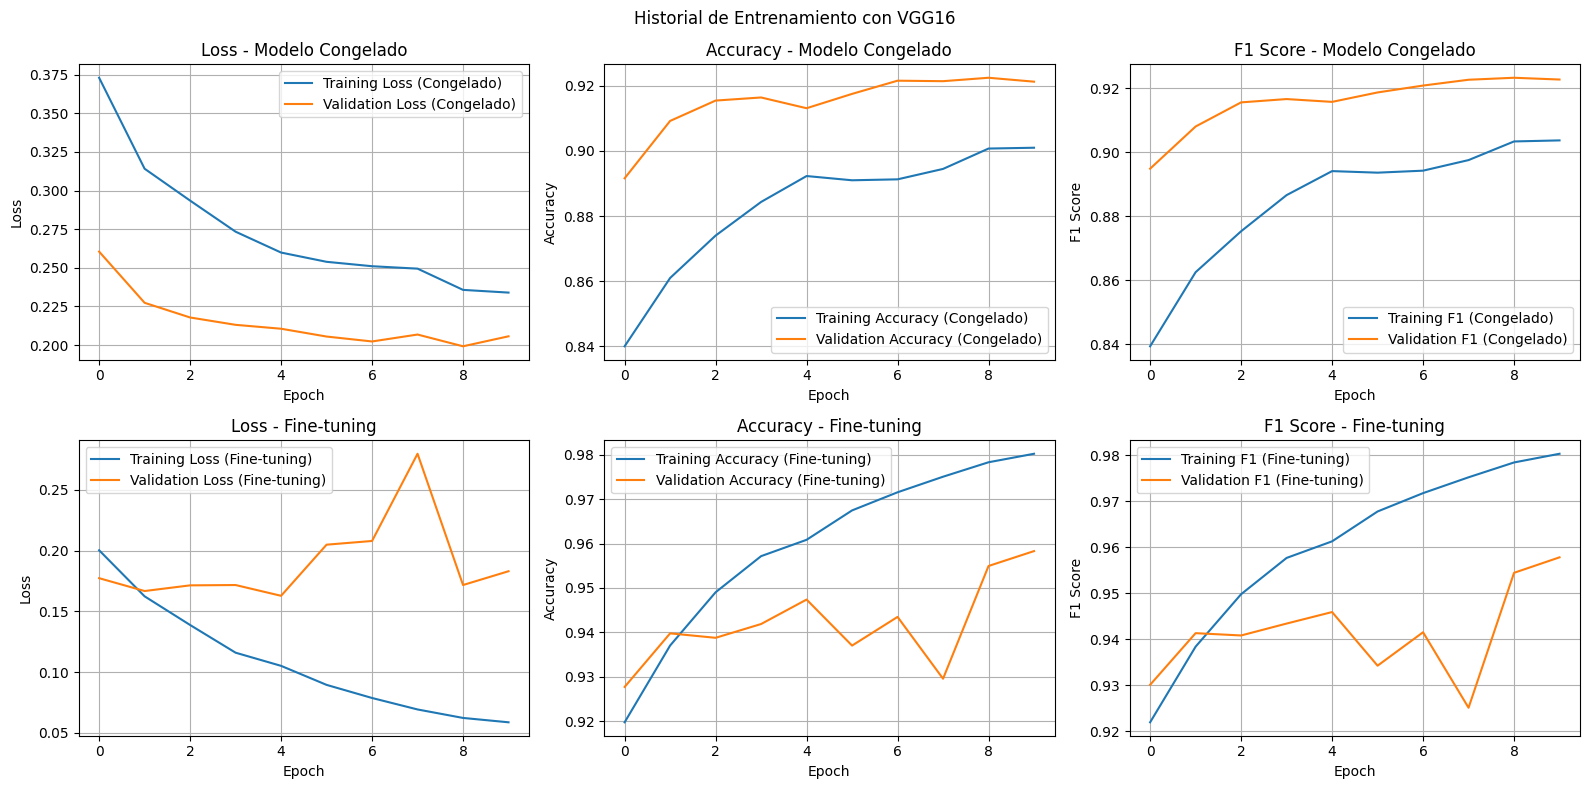

In [31]:
# Graficar historial de entrenamiento
plt.figure(figsize=(16, 8))
plt.suptitle('Historial de Entrenamiento con VGG16')

# Primera fila: Entrenamiento con VGG16 Congelado
# Loss 
plt.subplot(2, 3, 1) 
plt.plot(history.history['loss'], label='Training Loss (Congelado)')
plt.plot(history.history['val_loss'], label='Validation Loss (Congelado)')
plt.title('Loss - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 3, 2) 
plt.plot(history.history['accuracy'], label='Training Accuracy (Congelado)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Congelado)')
plt.title('Accuracy - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 3) 
plt.plot(history.history['f1_score'], label='Training F1 (Congelado)')
plt.plot(history.history['val_f1_score'], label='Validation F1 (Congelado)')
plt.title('F1 Score - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

# Segunda fila: Entrenamiento con VGG16 Descongelado

# Loss 
plt.subplot(2, 3, 4) 
plt.plot(history_unfrozen.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_unfrozen.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 
plt.subplot(2, 3, 5) 
plt.plot(history_unfrozen.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 6) 
plt.plot(history_unfrozen.history['f1_score'], label='Training F1 (Fine-tuning)')
plt.plot(history_unfrozen.history['val_f1_score'], label='Validation F1 (Fine-tuning)')
plt.title('F1 Score - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('historial_entrenamiento_vgg16_combinado.png')
plt.show()

## 9. Hacer predicciones en el conjunto de prueba

In [14]:
# Evaluar el modelo en el conjunto de prueba
# Create test dataset
test_dir = 'test'  

# Crear sets de entrenamiento y validación
data_dir = os.path.join(file_path, test_dir)

# Obtener rutas de imágenes y etiquetas
all_image_paths , all_labels = get_labels(data_dir) 

test_ds = load_dataset(all_image_paths, all_labels, batch_size)

# Evaluate with dataset
test_results = model.evaluate(test_ds, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9157 - f1_score: 0.9177 - loss: 0.2064


## 10. Visualizar predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


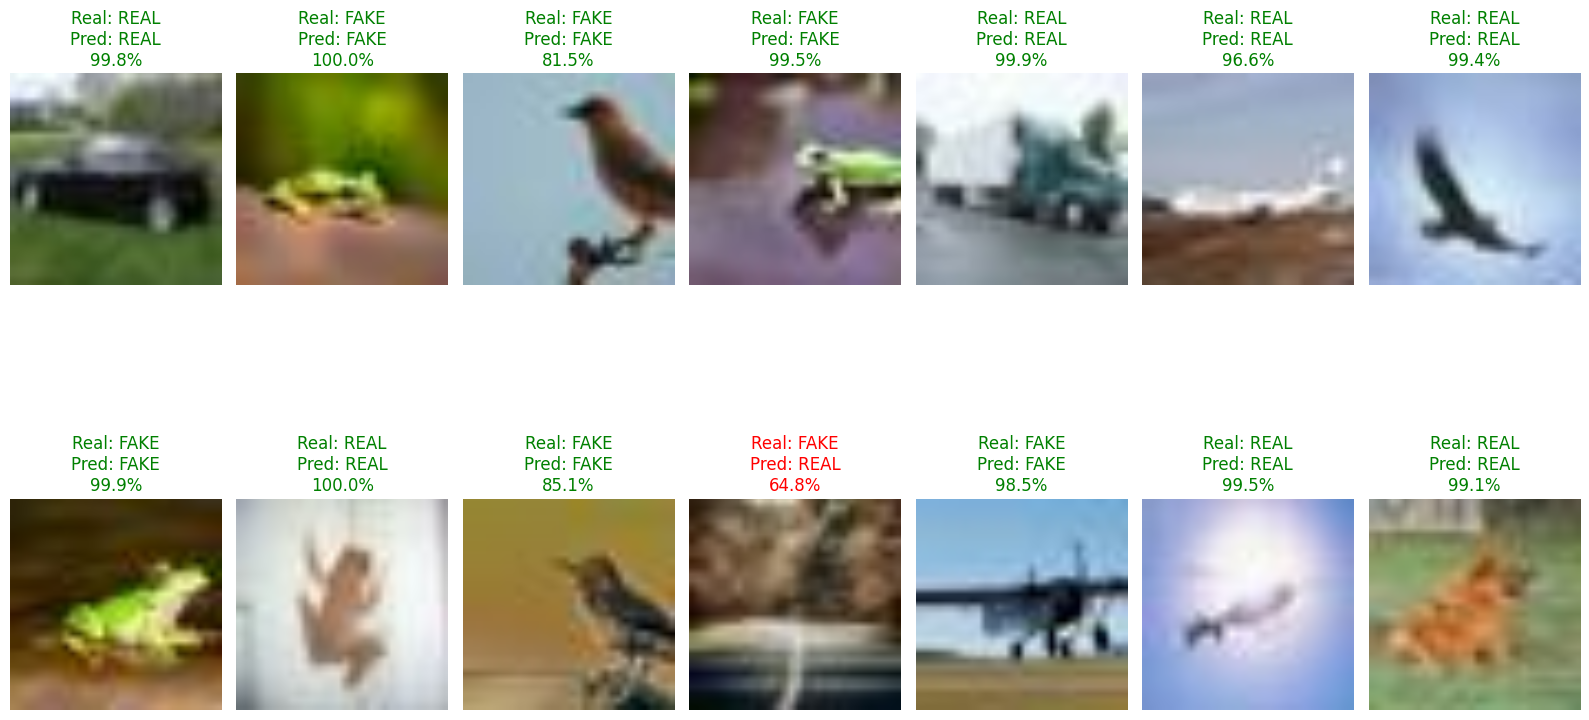

Métricas en la muestra visualizada:
Accuracy: 0.9286
Precision score: 0.8750
Recall score: 1.0000
F1 score: 0.9333

Matriz de confusión:
[[6 1]
 [0 7]]


In [15]:
# Obtener imágenes y etiquetas de test_ds
sample_size = 14  # Número de imágenes a visualizar
images_to_show = []
labels_to_show = []
count = 0

# Recopilar algunas imágenes del dataset de prueba
for images, labels in test_ds.take(3):  # Tomar 3 batches para tener suficientes imágenes
    for i in range(len(images)):
        if count >= sample_size:
            break
        images_to_show.append(images[i].numpy())
        labels_to_show.append(labels[i].numpy()[0])
        count += 1
    if count >= sample_size:
        break

# Realizar predicciones
predictions = model.predict(np.array(images_to_show))
predictions = predictions.flatten()
pred_classes = (predictions > 0.5).astype(int)

# Visualizar imágenes con sus predicciones
plt.figure(figsize=(16, 10))
for i in range(len(images_to_show)):
    plt.subplot(2, 7, i+1)
    plt.imshow(images_to_show[i])
    
    true_class = ['FAKE', 'REAL'][int(labels_to_show[i])]
    pred_class = ['FAKE', 'REAL'][pred_classes[i]]
    confidence = predictions[i] * 100 if pred_classes[i] == 1 else (1 - predictions[i]) * 100
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"Real: {true_class}\nPred: {pred_class}\n{confidence:.1f}%", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Calcular métricas de rendimiento
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(labels_to_show, pred_classes)
precision = precision_score(labels_to_show, pred_classes, average='binary')
recall = recall_score(labels_to_show, pred_classes, average='binary')
f1 = f1_score(labels_to_show, pred_classes, average='binary')
conf_matrix = confusion_matrix(labels_to_show, pred_classes)

print(f"Métricas en la muestra visualizada:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision score: {precision:.4f}")
print(f"Recall score: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print("\nMatriz de confusión:")
print(conf_matrix)

# Explicabilidad del Modelo

In [33]:
# Cargamos imagenes de prueba
img_paths = ["/mnt/d/test/000a8769fc78487a9163852d7a2a048d.jpg", "/mnt/d/test/000aaacc53f94d708736b845704dcaaa.jpg", "/mnt/d/test/000c4ee98dfa437195b2b6881da89dcf.jpg", "/mnt/d/test/000c403fd07740e3aef76244ff31743e.jpg", "/mnt/d/test/000fe90b4fb14fca9d250167e77e3d10.jpg", "/mnt/d/test/000ff55056384d61972bda1b6bd80701.jpg"]

# Preprocesar imágenes y almacenarlas en un array
images = np.zeros((len(img_paths), img_size, img_size, 3))
for i, img_path in enumerate(img_paths):
    img = Image.open(img_path).resize((img_size, img_size))
    img = img.convert('RGB')  # Ensure RGB format
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    images[i] = img_array

## LIME

Modelo cargado correctamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)


/tmp/ipykernel_21926/372143280.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Valor de predicción: [0.]
Predicción: FAKE (Confianza: 100.00%)


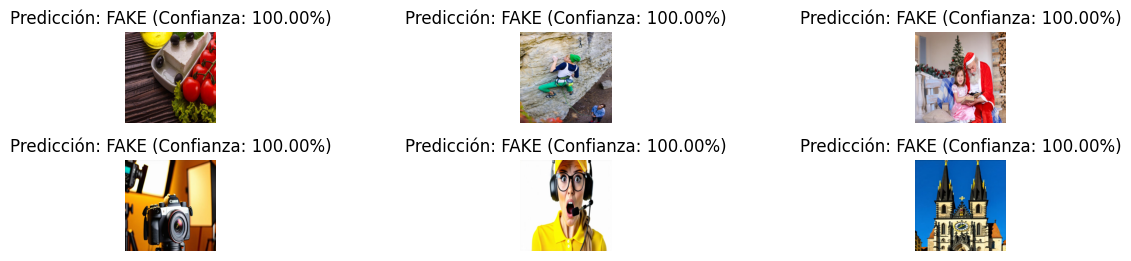

In [34]:
# Ejemplo de cómo cargar el modelo guardado para inferencia

model = tf.keras.models.load_model('VGG_CIFAKE.keras')
#model = tf.keras.models.load_model('CIFAKE.keras')
print("Modelo cargado correctamente")

# Probar con una sola imagen
def predict_single_image(img_array, model):     
    # Add batch dimension if needed
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    
    # Predecir
    prediction = model.predict(img_array)[0]
    print(f"Valor de predicción: {prediction}")
    prediction = float(prediction)
    predicted_class = 1 if prediction >= 0.5 else 0
    confidence = prediction * 100 if predicted_class == 1 else (1 - prediction) * 100
    
    return ['FAKE', 'REAL'][predicted_class], confidence


# Realizar predicción
plt.figure(figsize=(12, 4))
for i, image in enumerate(images):
    result, confidence = predict_single_image(image, model)
    print(f"Predicción: {result} (Confianza: {confidence:.2f}%)")
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.title(f"Predicción: {result} (Confianza: {confidence:.2f}%)")
    plt.tight_layout()
    plt.imshow(image)
plt.show()

In [35]:
image = images[-3]  # Cambia esto a la ruta de tu imagen

explainer = lime_image.LimeImageExplainer()

# Realizar predicción
explanation = explainer.explain_instance(
    image,  
    model, 
    top_labels=2,
    hide_color=0,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicción real del modelo: 0.0
Predicción real del modelo: FAKE


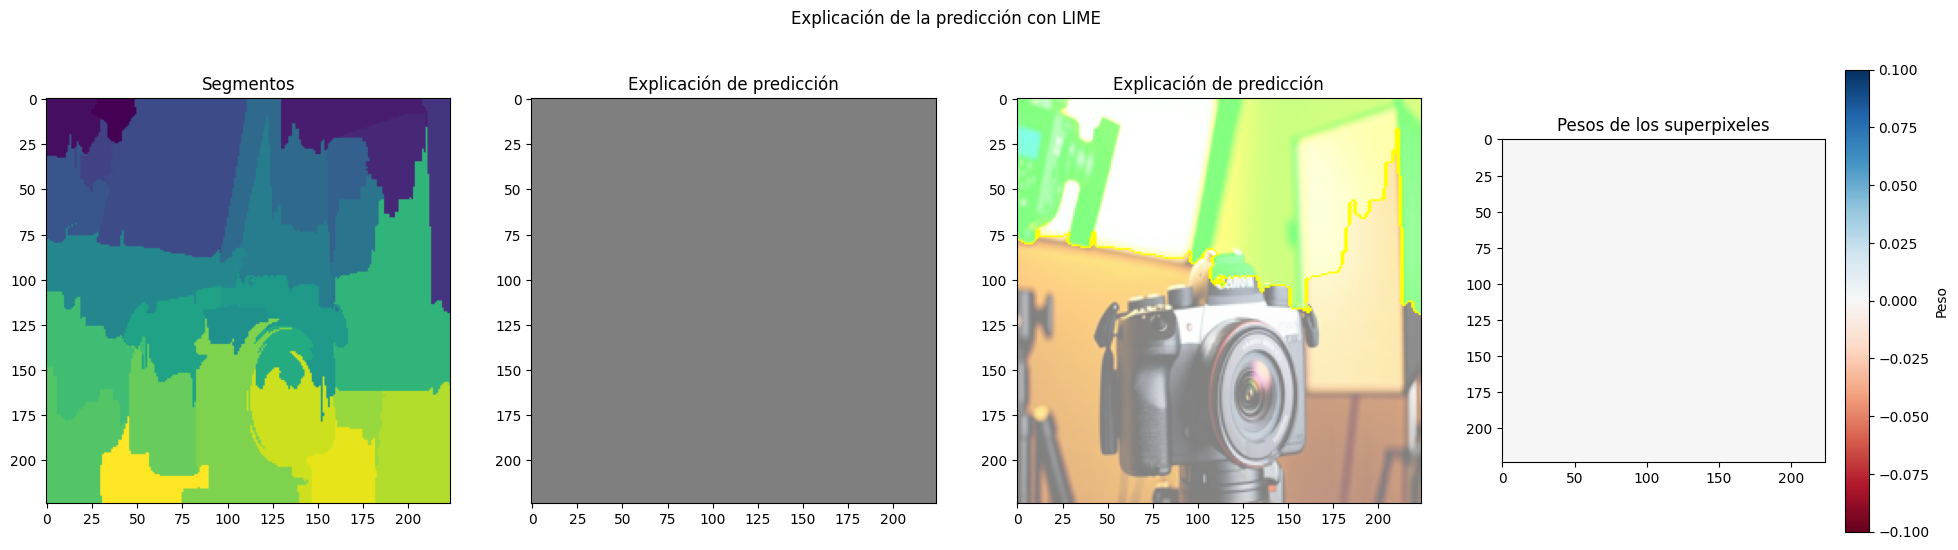

In [36]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=12,
    hide_rest=True,
)

# Prediccion real del modelo
pred = model.predict(np.expand_dims(image, axis=0))
print(f"Predicción real del modelo: {pred[0][0]}")
print(f"Predicción real del modelo: {['FAKE', 'REAL'][int(pred[0][0] >= 0.5)]}")


plt.figure(figsize=(24, 6))
plt.suptitle('Explicación de la predicción con LIME')
plt.subplot(1, 4, 1)
plt.imshow(explanation.segments)
plt.title("Segmentos")
plt.subplot(1, 4, 2)
plt.title("Explicación de predicción")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(1, 4, 3)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=12,
    hide_rest=False,
)
plt.title("Explicación de predicción")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(1, 4, 4)

# Seleccionar el índice de la clase más probable
top_class_index = explanation.top_labels[0]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()


## GradCAM

### Para VGG16

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore 
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm

replace2linear = ReplaceToLinear()
score = BinaryScore(target_values=1)


gradcam = Gradcam(
    model,
    model_modifier=replace2linear,
    clone=True
)

# Generar Grad-CAM para las imagenes

cam = gradcam(
    score,
    images,
    penultimate_layer=-1
)

num_images = len(images)
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(5 * num_images, 5))
if num_images == 1: # Ensure axes is always iterable
    axes = [axes]

for i, current_img in enumerate(images):
    
    # Convertir el mapa de calor a un formato adecuado para la visualización
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    ax = axes[i]
    ax.set_title(f"Imagen {i+1}")
    ax.imshow(current_img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.axis('off')

plt.tight_layout()
plt.show()


TypeError: Gradcam.__call__() got an unexpected keyword argument 'smooth'